# Dvojke ali trojke

**Projektna naloga pri predmetu Programiranje 1**

Analiziral bom vse tekme lige NBA iz sezone 2020/2021. Vsa statistika je bila pridobljena s spletne strani [ESPN](https://www.espn.com/nba/scoreboard).

Začetne hipoteze:
1. Katere ekipe so imele uspešnejšo sezono - tiste, ki so pretežno metale za dve točki ali za tri točke?
2. Ali so bile v medsebojnih tekmah uspešnejše ekipe, ki so več metale za dve točki ali za tri točke?
3. Ali obstaja povezava med dominantnim načinom igre (igra pod košem ali igra z meti za tri točke) in ostalimi pomembnimi statističnimi podatki?

# 0. Priprava podatkov

Preden začnemo z analizo podatkov, jih moramo naprej uvesti, nato pa jih še dodatno obdelati. Potrebovali bomo, namreč, še nekaj podatkov, ki jih ne moremo direktno uvesti, ampak jih moramo izračunati iz uvezenih podatkov. 

In [2]:
import pandas as pd
tekme_redne = pd.read_csv('statistika-v-csv/tekme_redne.csv', index_col='Tekma',encoding = "utf-8")
tekme_playoff = pd.read_csv('statistika-v-csv/tekme_playoff.csv', index_col='Tekma',encoding = "utf-8")
ekipe = pd.read_csv('statistika-v-csv/ekipe.csv', index_col='Team',encoding = "utf-8")
pd.options.display.max_rows = 10
%matplotlib inline

Zdaj si lahko ogledamo podatke, ki smo jih uvezli. Prva tabela vsebuje podatke o vseh tekmah NBA lige v rednem delu sezone 2020/21. Okrajšave v tabeli imajo naslednje pomene:
* FG - število uspešnih in vseh metov iz igre (za dve in za tri točke skupaj, brez prostih metov)
* 3PT - število uspešnih in vseh metov za tri točke
* FT - število uspešnih in vseh prostih metov
* OREB - skoki v napadu
* DREB - skoki v obrambi
* REB - vsi skoki (v napadu in obrambi skupaj)
* AST - asistence
* STL - ukradene žoge
* BLK - blokirani meti na koš
* TO - izgubljene žoge
* PF - osebne napake
* PTS - končno število točk

In [3]:
tekme_redne

,Team,FG,3PT,FT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS
Tekma,,,,,,,,,,,,,
0,1,37-99,10-33,15-23,13,34,47,26,6,6,18,24,99
0,2,42-92,15-35,26-32,13,44,57,24,11,7,20,22,125
1,3,44-93,14-40,14-19,11,29,40,22,10,3,16,29,116
1,4,38-81,9-29,24-31,8,37,45,22,4,2,19,20,109
2,5,45-90,16-44,8-15,8,24,32,29,10,4,15,17,114
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,12,46-94,19-40,17-23,9,32,41,35,8,5,11,27,128
1100,22,44-98,14-37,14-15,10,26,36,20,8,2,6,20,116
1100,24,46-87,18-43,22-26,11,40,51,24,3,6,13,16,132


Druga tabela vsebuje identifikacijske številke NBA ekip s standardnimi okrajšavami njihovih imen:

In [86]:
ekipe

,Name
Team,
1,GS
2,BKN
3,LAC
4,LAL
5,CHA
...,...
26,HOU
27,PHX
28,DAL


Podatki o vseh treh tipih meta (iz igre, za tri točke, prosti met) so v obliki, v kateri bomo težko z njimi delali, zato jih spremenimo v bolj obvladljivo obliko. Ob tem še izbrišemo podatke o All-Star tekmi, ki nas ne bo zanimala, saj zelo odstopa od ostalih tekem.

In [4]:
tekme_redne = tekme_redne[tekme_redne.Team != 31] #izbrišemo All-Star tekmo
tekme_redne = tekme_redne[tekme_redne.Team != 32]
ekipe = ekipe.drop([31,32]) #izbrišemo All-Star ekipi
tekme_redne[["FGM", "FGA"]] = tekme_redne["FG"].str.split("-", expand = True)
tekme_redne[["3PM", "3PA"]] = tekme_redne["3PT"].str.split("-", expand = True)
tekme_redne[["FTM", "FTA"]] = tekme_redne["FT"].str.split("-", expand = True)
tekme_playoff[["FGM", "FGA"]] = tekme_playoff["FG"].str.split("-", expand = True)
tekme_playoff[["3PM", "3PA"]] = tekme_playoff["3PT"].str.split("-", expand = True)
tekme_playoff[["FTM", "FTA"]] = tekme_playoff["FT"].str.split("-", expand = True)
tekme_redne = tekme_redne.drop(columns=['FG','3PT','FT'])
tekme_playoff = tekme_playoff.drop(columns=['FG','3PT','FT'])


Zaradi lažjega dela, spremenimo še tip podatkov v tabeli s tekmami.

In [5]:
tekme_redne = tekme_redne.astype(float)
tekme_playoff = tekme_playoff.astype(float)
tekme_redne["Team"] = tekme_redne["Team"].astype(int)
tekme_playoff["Team"] = tekme_playoff["Team"].astype(int)

Zdaj pa se lotimo računanja podatkov, ki nas bodo zanimali za vsako posamezno tekmo. To so: uspešnost meta iz igre, meta za tri ter prostih metov in 3NG faktor, ki ga bomo kasneje opisali.

In [6]:
expected_value = 1.06
tekme_redne["FG%"] = 100 * tekme_redne["FGM"]/tekme_redne["FGA"]
tekme_redne["3P%"] = 100 * tekme_redne["3PM"]/tekme_redne["3PA"]
tekme_redne["FT%"] = 100 * tekme_redne["FTM"]/tekme_redne["FTA"]
tekme_redne["3NG"] = 3 * ((3 - expected_value) * tekme_redne["3PM"] - expected_value * (tekme_redne["3PA"] - tekme_redne["3PM"]))
tekme_playoff["FG%"] = 100 * tekme_playoff["FGM"]/tekme_playoff["FGA"]
tekme_playoff["3P%"] = 100 * tekme_playoff["3PM"]/tekme_playoff["3PA"]
tekme_playoff["FT%"] = 100 * tekme_playoff["FTM"]/tekme_playoff["FTA"]
tekme_playoff["3NG"] = 3 * ((3 - expected_value) * tekme_playoff["3PM"] - expected_value * (tekme_playoff["3PA"] - tekme_playoff["3PM"]))
tekme_redne["FG%"] = tekme_redne["FG%"].round(decimals=2)
tekme_redne["3P%"] = tekme_redne["3P%"].round(decimals=2)
tekme_redne["FT%"] = tekme_redne["FT%"].round(decimals=2)
tekme_playoff["FG%"] = tekme_playoff["FG%"].round(decimals=2)
tekme_playoff["3P%"] = tekme_playoff["3P%"].round(decimals=2)
tekme_playoff["FT%"] = tekme_playoff["FT%"].round(decimals=2)

Izačunamo še na kateri tekmi je kdo zmagal, da lahko dobimo lestvico na koncu sezone. 

In [8]:
zmaga_poraz_redne = []

for i in range(tekme_redne["PTS"].size):
    if i % 2 == 0:
        if tekme_redne["PTS"].iloc[i] > tekme_redne["PTS"].iloc[i + 1]:
            zmaga_poraz_redne.append(1)
        else:
            zmaga_poraz_redne.append(0)
    else:
        if tekme_redne["PTS"].iloc[i] > tekme_redne["PTS"].iloc[i - 1]:
            zmaga_poraz_redne.append(1)
        else:
            zmaga_poraz_redne.append(0)

tekme_redne["W/L"] = zmaga_poraz_redne

zmaga_poraz_playoff = []

for i in range(tekme_playoff["PTS"].size):
    if i % 2 == 0:
        if tekme_playoff["PTS"].iloc[i] > tekme_playoff["PTS"].iloc[i + 1]:
            zmaga_poraz_playoff.append(1)
        else:
            zmaga_poraz_playoff.append(0)
    else:
        if tekme_playoff["PTS"].iloc[i] > tekme_playoff["PTS"].iloc[i - 1]:
            zmaga_poraz_playoff.append(1)
        else:
            zmaga_poraz_playoff.append(0)

tekme_playoff["W/L"] = zmaga_poraz_playoff

Ugotavljali bomo, ali obstaja kakšna zveza med metom za tri točke in številom točk, ki jih je ekipa prejela od nasprotnika, zato priskrbimo še slednji podatek za vsako tekmo posebej.

In [9]:
pts_against = []

for i in range(tekme_redne["PTS"].size//2):
    pts_against.append(tekme_redne["PTS"].iloc[2 * i + 1])
    pts_against.append(tekme_redne["PTS"].iloc[2 * i])

tekme_redne["PTSA"] = pts_against

pts_against = []

for i in range(tekme_playoff["PTS"].size//2):
    pts_against.append(tekme_playoff["PTS"].iloc[2 * i + 1])
    pts_against.append(tekme_playoff["PTS"].iloc[2 * i])

tekme_playoff["PTSA"] = pts_against

Izračunamo vse statistične podatke vseh ekip skozi celotno sezono.

In [10]:
tekme_redne["3PA/FGA"] = tekme_redne["3PA"]/tekme_redne["FGA"]
tekme_playoff["3PA/FGA"] = tekme_playoff["3PA"]/tekme_playoff["FGA"]
ekipe_redno_2 = tekme_redne.groupby("Team")
ekipe_playoff_2 = tekme_playoff.groupby("Team")
ekipe_redno = ekipe_redno_2.sum()
ekipe_playoff = ekipe_playoff_2.sum()
ekipe_redno["FG%"] = ekipe_redno["FG%"]/ekipe_redno_2.count()["FG%"]
ekipe_redno["3P%"] = ekipe_redno["3P%"]/ekipe_redno_2.count()["3P%"]
ekipe_redno["FT%"] = ekipe_redno["FT%"]/ekipe_redno_2.count()["FT%"]
ekipe_redno["3NG"] = 3 * ((3 - expected_value) * ekipe_redno["3PM"] - expected_value * (ekipe_redno["3PA"] - ekipe_redno["3PM"]))
ekipe_playoff["FG%"] = ekipe_playoff["FG%"]/ekipe_playoff_2.count()["FG%"]
ekipe_playoff["3P%"] = ekipe_playoff["3P%"]/ekipe_playoff_2.count()["3P%"]
ekipe_playoff["FT%"] = ekipe_playoff["FT%"]/ekipe_playoff_2.count()["FT%"]
ekipe_redno["3PA/FGA"] = ekipe_redno["3PA"]/ekipe_redno["FGA"]
ekipe_playoff["3PA/FGA"] = ekipe_playoff["3PA"]/ekipe_playoff["FGA"]
ekipe_playoff["3NG"] = 3 * ((3 - expected_value) * ekipe_playoff["3PM"] - expected_value * (ekipe_playoff["3PA"] - ekipe_playoff["3PM"]))
ekipe_redno = ekipe_redno.rename(columns={"W/L" : "WINS"})
ekipe_playoff = ekipe_playoff.rename(columns={"W/L" : "WINS"})
ekipe_redno["WIN%"] = 100 * ekipe_redno["WINS"]/ekipe_redno_2.count()["W/L"]
ekipe_playoff["WIN%"] = 100 * ekipe_playoff["WINS"]/ekipe_playoff_2.count()["W/L"]

Na koncu le še uredimo izračunane podatke tako, da dobimo lestvice ekip na koncu sezone, in sicer glede na delež zmag, uspešnost meta za tri in 3NG faktor. S temi lestvicami dobimo vpogled v okvirne vrednosti podatkov, ki jih bomo obravnavali. Nove okrajšave v lestvicah imajo naslednje pomene:

* FGM - število uspešnih metov iz igre
* FGA - število vseh metov iz igre
* 3PM - število uspešnih metov za tri točke
* 3PA - število vseh metov za tri točke
* FTM - število uspešnih prostih metov
* FTA - število vseh prostih metov
* FG% - delež uspešnih metov iz igre glede na vse mete iz igre, izražen v procentih
* 3P% - delež uspešnih metov za tri točke glede na vse mete za tri točke, izražen v procentih
* FT% - delež uspešnih prostih metov glede na vse proste mete, izražen v procentih
* 3NG - 3NG koeficient
* WINS - število vseh zmag v sezoni
* PTSA - število točk, ki jih je ekipa prejela od vseh nasprotnikov skupaj
* WIN% - delež vseh zmag v sezoni glede na število vseh tekem v sezoni, izražen v procentih

In [13]:
lestvica_redno = pd.merge(ekipe, ekipe_redno, left_index=True, right_index=True)
lestvica_redno = lestvica_redno.sort_values(by='WIN%',ascending=False)
najvec_relativno_za_tri_redno = pd.merge(ekipe, ekipe_redno, left_index=True, right_index=True)
najvec_relativno_za_tri_redno = najvec_relativno_za_tri_redno.sort_values(by='3PA/FGA',ascending=False)
najuspesneje_za_tri = pd.merge(ekipe, ekipe_redno, left_index=True, right_index=True)
najuspesneje_za_tri = najuspesneje_za_tri.sort_values(by='3P%',ascending=False)
najboljsi_3NG = pd.merge(ekipe, ekipe_redno, left_index=True, right_index=True)
najboljsi_3NG = najboljsi_3NG.sort_values(by='3NG',ascending=False)

Lestvica glede na delež zmag

In [88]:
lestvica_redno

,Name,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,...,FTM,FTA,FG%,3P%,FT%,3NG,WINS,PTSA,3PA/FGA,WIN%
Team,,,,,,,,,,,,,,,,,,,,,
23,UTAH,765.0,2708.0,3473.0,1703.0,475.0,370.0,973.0,1335.0,8382.0,...,1235.0,1546.0,46.914167,38.772917,79.325139,993.36,52,7716.0,0.488335,72.222222
27,PHX,613.0,2380.0,2993.0,1882.0,505.0,298.0,838.0,1335.0,8071.0,...,1101.0,1316.0,49.142429,37.759000,83.673714,532.50,49,7658.0,0.392840,70.000000
12,PHI,722.0,2521.0,3243.0,1706.0,655.0,447.0,988.0,1456.0,8182.0,...,1409.0,1836.0,47.688611,37.599444,76.752778,401.58,49,7780.0,0.346652,68.055556
22,DEN,749.0,2419.0,3168.0,1908.0,575.0,322.0,910.0,1354.0,8176.0,...,1106.0,1375.0,48.666197,37.876901,80.862958,529.32,47,7808.0,0.382589,66.197183
2,BKN,620.0,2479.0,3099.0,1877.0,471.0,365.0,910.0,1327.0,8287.0,...,1259.0,1568.0,49.445143,38.684429,80.265143,848.70,46,8021.0,0.414013,65.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,CLE,751.0,2328.0,3079.0,1716.0,559.0,325.0,1039.0,1308.0,7476.0,...,1200.0,1614.0,45.044028,33.663194,74.271250,-331.56,22,8084.0,0.346826,30.555556
25,OKC,705.0,2531.0,3236.0,1556.0,496.0,316.0,1095.0,1291.0,7446.0,...,1104.0,1520.0,44.150423,33.838732,72.642113,-349.74,21,8217.0,0.399263,29.577465
10,ORL,746.0,2527.0,3273.0,1572.0,495.0,320.0,882.0,1235.0,7488.0,...,1196.0,1543.0,42.935556,33.912361,77.584444,-216.66,21,8158.0,0.356175,29.166667


Lestvica glede na uspešnost meta za tri

In [16]:
najuspesneje_za_tri

,Name,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,...,FTM,FTA,FG%,3P%,FT%,3NG,WINS,PTSA,3PA/FGA,WIN%
Team,,,,,,,,,,,,,,,,,,,,,
3,LAC,669.0,2473.0,3142.0,1724.0,500.0,291.0,877.0,1351.0,8088.0,...,1144.0,1363.0,48.213944,41.164085,83.892254,1252.38,46,7656.0,0.398671,64.788732
7,NY,697.0,2554.0,3251.0,1541.0,507.0,365.0,875.0,1473.0,7706.0,...,1181.0,1506.0,45.657222,39.133611,78.591528,744.66,41,7540.0,0.347358,56.944444
23,UTAH,765.0,2708.0,3473.0,1703.0,475.0,370.0,973.0,1335.0,8382.0,...,1235.0,1546.0,46.914167,38.772917,79.325139,993.36,52,7716.0,0.488335,72.222222
2,BKN,620.0,2479.0,3099.0,1877.0,471.0,365.0,910.0,1327.0,8287.0,...,1259.0,1568.0,49.445143,38.684429,80.265143,848.70,46,8021.0,0.414013,65.714286
24,POR,766.0,2441.0,3207.0,1531.0,496.0,364.0,775.0,1363.0,8360.0,...,1282.0,1558.0,45.453611,38.602917,82.074583,841.98,42,8231.0,0.448155,58.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,SA,659.0,2454.0,3113.0,1729.0,500.0,361.0,781.0,1285.0,7877.0,...,1240.0,1565.0,46.191408,34.735634,79.381972,-52.14,33,8000.0,0.315060,46.478873
10,ORL,746.0,2527.0,3273.0,1572.0,495.0,320.0,882.0,1235.0,7488.0,...,1196.0,1543.0,42.935556,33.912361,77.584444,-216.66,21,8158.0,0.356175,29.166667
26,HOU,671.0,2396.0,3067.0,1699.0,546.0,362.0,1026.0,1407.0,7833.0,...,1189.0,1606.0,44.414583,33.865972,74.110694,-367.14,17,8402.0,0.458798,23.611111


Lestvica glede na 3NG faktor

In [17]:
najboljsi_3NG

,Name,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,...,FTM,FTA,FG%,3P%,FT%,3NG,WINS,PTSA,3PA/FGA,WIN%
Team,,,,,,,,,,,,,,,,,,,,,
3,LAC,669.0,2473.0,3142.0,1724.0,500.0,291.0,877.0,1351.0,8088.0,...,1144.0,1363.0,48.213944,41.164085,83.892254,1252.38,46,7656.0,0.398671,64.788732
23,UTAH,765.0,2708.0,3473.0,1703.0,475.0,370.0,973.0,1335.0,8382.0,...,1235.0,1546.0,46.914167,38.772917,79.325139,993.36,52,7716.0,0.488335,72.222222
2,BKN,620.0,2479.0,3099.0,1877.0,471.0,365.0,910.0,1327.0,8287.0,...,1259.0,1568.0,49.445143,38.684429,80.265143,848.70,46,8021.0,0.414013,65.714286
24,POR,766.0,2441.0,3207.0,1531.0,496.0,364.0,775.0,1363.0,8360.0,...,1282.0,1558.0,45.453611,38.602917,82.074583,841.98,42,8231.0,0.448155,58.333333
29,MIL,707.0,2601.0,3308.0,1766.0,564.0,321.0,917.0,1192.0,8281.0,...,1130.0,1486.0,48.700145,38.381884,76.200000,778.20,45,7890.0,0.404168,65.217391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,DET,681.0,2345.0,3026.0,1704.0,519.0,367.0,1009.0,1449.0,7547.0,...,1265.0,1662.0,45.142113,34.958310,75.956761,-98.22,19,7893.0,0.383690,26.760563
10,ORL,746.0,2527.0,3273.0,1572.0,495.0,320.0,882.0,1235.0,7488.0,...,1196.0,1543.0,42.935556,33.912361,77.584444,-216.66,21,8158.0,0.356175,29.166667
6,CLE,751.0,2328.0,3079.0,1716.0,559.0,325.0,1039.0,1308.0,7476.0,...,1200.0,1614.0,45.044028,33.663194,74.271250,-331.56,22,8084.0,0.346826,30.555556


V nadaljevanju bomo obravnavali vpliv meta za tri točke na dva načina. Najprej bomo pogledali, kako met za tri točke vpliva na rezultate ekip v celotni sezoni, nato pa še vpliv meta za tri točke na posameznih tekmah. Izkazalo se bo, da je vpliv na uspešnost ekip dejansko različen v teh dveh primerih.

# 1. Vpliv metov za tri točke na uspešnost ekip na koncu sezone

Pogledali bomo, kako trije ključni faktorji, povezani z metom za tri točke, vplivajo na uspešnost ekip na koncu sezone. Ti faktorji so: število metov za tri točke (3PA), uspešnost meta za tri točke (3P%) in 3NG koeficient, ki je definiran na naslednji način: 
$$ \mathit{3NG = 3 * (3PM * (3 - EV) - (3PA - 3PM) * EV) = (3 * 3P\% - EV) * 3PA}, $$
kjer je $EV$ pričakovano število točk, ki ga bo neka ekipa dosegla v enem napadu. V tej analizi smo privzeli, da je $EV = 1,06$. Za zdaj opazimo le, da je 3NG odvisen tako od števila metov za tri točke, kot tudi od uspešnosti meta za tri točke, kasneje pa se bomo temu koeficientu posvetili še podrobneje.

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Število vseh metov za tri', ylabel='Delež zmag izmed vseh tekem [%]'>

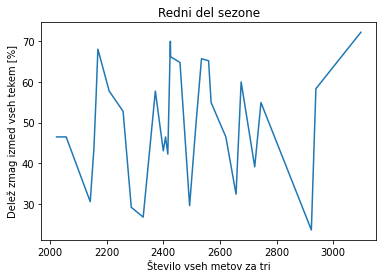

In [18]:
lestvica_redno.groupby("3PA")["WIN%"].mean().plot(title = "Redni del sezone", xlabel="Število vseh metov za tri", ylabel="Delež zmag izmed vseh tekem [%]")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Uspešnost meta za tri [%]', ylabel='Delež zmag izmed vseh tekem [%]'>

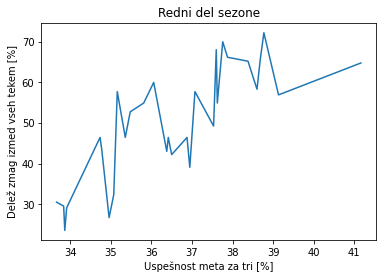

In [19]:
lestvica_redno.groupby("3P%")["WIN%"].mean().plot(title = "Redni del sezone", xlabel="Uspešnost meta za tri [%]", ylabel="Delež zmag izmed vseh tekem [%]")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='3NG koeficient', ylabel='Delež zmag izmed vseh tekem [%]'>

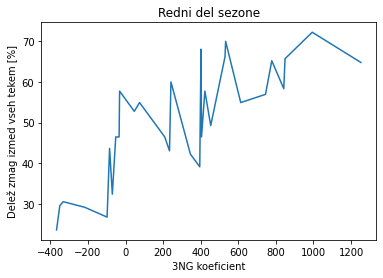

In [20]:
ekipe_redno.groupby("3NG")["WIN%"].mean().plot(title = "Redni del sezone", xlabel="3NG koeficient", ylabel="Delež zmag izmed vseh tekem [%]")

In [21]:
razlika_v_tockah = []
razlika_v_delezu_meta_za_tri = []
povprecje_meta_za_tri = []
razlika_v_metu_za_tri = []
razlika_v_metu_za_tri_sezona = []
razlika_3NG = []

for i in range(tekme_redne["3P%"].size//2):
    razlika_v_delezu_meta_za_tri.append(tekme_redne["3P%"].iloc[2 * i] - tekme_redne["3P%"].iloc[2 * i + 1])
    razlika_v_metu_za_tri.append(tekme_redne["3PA"].iloc[2 * i] - tekme_redne["3PA"].iloc[2 * i + 1])
    razlika_v_tockah.append(tekme_redne["PTS"].iloc[2 * i] - tekme_redne["PTS"].iloc[2 * i + 1])
    razlika_v_delezu_meta_za_tri.append(tekme_redne["3P%"].iloc[2 * i + 1] - tekme_redne["3P%"].iloc[2 * i])
    razlika_v_metu_za_tri.append(tekme_redne["3PA"].iloc[2 * i + 1] - tekme_redne["3PA"].iloc[2 * i])
    razlika_v_tockah.append(tekme_redne["PTS"].iloc[2 * i + 1] - tekme_redne["PTS"].iloc[2 * i])
    prva_ekipa = tekme_redne["Team"].iloc[2 * i]
    druga_ekipa = tekme_redne["Team"].iloc[2 * i + 1]
    razlika_v_metu_za_tri_sezona.append(ekipe_redno["3P%"].loc[prva_ekipa] - ekipe_redno["3P%"].loc[druga_ekipa])
    razlika_v_metu_za_tri_sezona.append(ekipe_redno["3P%"].loc[druga_ekipa] - ekipe_redno["3P%"].loc[prva_ekipa])
    razlika_3NG.append(tekme_redne["3NG"].iloc[2 * i] - tekme_redne["3NG"].iloc[2 * i + 1])
    razlika_3NG.append(tekme_redne["3NG"].iloc[2 * i + 1] - tekme_redne["3NG"].iloc[2 * i])
    povprecje_meta_za_tri.extend(2 * [(tekme_redne["3P%"].iloc[2 * i + 1] + tekme_redne["3P%"].iloc[2 * i])/2])

data = {"PTS DIFF" : razlika_v_tockah, "3P% DIFF": razlika_v_delezu_meta_za_tri, "3P% DIFF SEASON" : razlika_v_metu_za_tri_sezona, "3PA DIFF" : razlika_v_metu_za_tri,
        "3NG DIFF" : razlika_3NG, "3P% AVG" : povprecje_meta_za_tri, "3NG" : tekme_redne["3NG"]}
tekme_redne2 = pd.DataFrame(data)
tekme_redne2 = tekme_redne2.rename_axis(index="Tekma")

razlika_v_tockah = []
razlika_v_delezu_meta_za_tri = []
povprecje_meta_za_tri = []
razlika_v_metu_za_tri = []
razlika_v_metu_za_tri_sezona = []
razlika_3NG = []

for i in range(tekme_playoff["3P%"].size//2):
    razlika_v_delezu_meta_za_tri.append(tekme_playoff["3P%"].iloc[2 * i] - tekme_playoff["3P%"].iloc[2 * i + 1])
    razlika_v_metu_za_tri.append(tekme_playoff["3PA"].iloc[2 * i] - tekme_playoff["3PA"].iloc[2 * i + 1])
    razlika_v_delezu_meta_za_tri.append(tekme_playoff["3P%"].iloc[2 * i + 1] - tekme_playoff["3P%"].iloc[2 * i])
    razlika_v_metu_za_tri.append(tekme_playoff["3PA"].iloc[2 * i + 1] - tekme_playoff["3PA"].iloc[2 * i])
    razlika_v_tockah.append(abs(tekme_playoff["PTS"].iloc[2 * i] - tekme_playoff["PTS"].iloc[2 * i + 1]))
    razlika_v_tockah.append(abs(tekme_playoff["PTS"].iloc[2 * i + 1] - tekme_playoff["PTS"].iloc[2 * i]))
    prva_ekipa = tekme_playoff["Team"].iloc[2 * i]
    druga_ekipa = tekme_playoff["Team"].iloc[2 * i + 1]
    razlika_v_metu_za_tri_sezona.append(ekipe_playoff["3P%"].loc[prva_ekipa] - ekipe_playoff["3P%"].loc[druga_ekipa])
    razlika_v_metu_za_tri_sezona.append(ekipe_playoff["3P%"].loc[druga_ekipa] - ekipe_playoff["3P%"].loc[prva_ekipa])
    razlika_3NG.append(tekme_playoff["3NG"].iloc[2 * i] - tekme_playoff["3NG"].iloc[2 * i + 1])
    razlika_3NG.append(tekme_playoff["3NG"].iloc[2 * i + 1] - tekme_playoff["3NG"].iloc[2 * i])
    povprecje_meta_za_tri.extend(2 * [(tekme_playoff["3P%"].iloc[2 * i + 1] + tekme_playoff["3P%"].iloc[2 * i])/2])

data = {"PTS DIFF" : razlika_v_tockah, "3P% DIFF": razlika_v_delezu_meta_za_tri, "3P% DIFF SEASON" : razlika_v_metu_za_tri_sezona, "3PA DIFF" : razlika_v_metu_za_tri,
        "3NG DIFF" : razlika_3NG, "3P% AVG" : povprecje_meta_za_tri, "3NG" : tekme_playoff["3NG"]}
tekme_playoff2 = pd.DataFrame(data)
tekme_playoff2 = tekme_playoff2.rename_axis(index="Tekma")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v uspešnosti meta za tri glede na nasprotno ekipo [%]', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

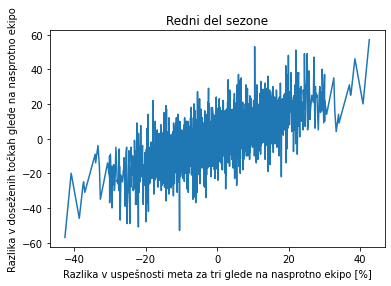

In [22]:
tekme_redne2.groupby("3P% DIFF")["PTS DIFF"].mean().plot(title="Redni del sezone", xlabel="Razlika v uspešnosti meta za tri glede na nasprotno ekipo [%]", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v uspešnosti meta za tri med zmagovalcem in poražencem [%]', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

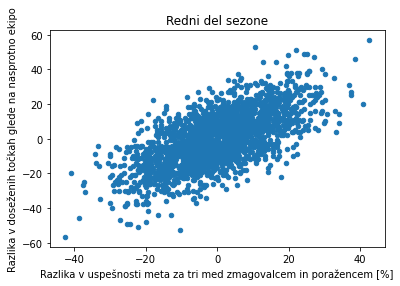

In [23]:
tekme_redne2.plot.scatter("3P% DIFF","PTS DIFF",title="Redni del sezone", xlabel="Razlika v uspešnosti meta za tri med zmagovalcem in poražencem [%]", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v številu metov za tri iglede na nasprotno ekipo', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

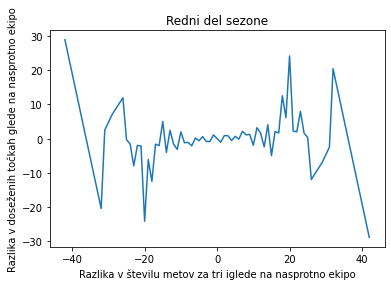

In [24]:
tekme_redne2.groupby("3PA DIFF")["PTS DIFF"].mean().plot(title="Redni del sezone", xlabel="Razlika v številu metov za tri iglede na nasprotno ekipo", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v deležu meta za tri izmed vseh metov glede na nasprotno ekipo [%]', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

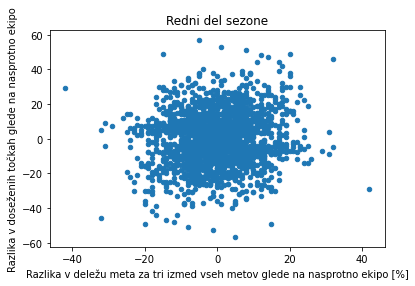

In [25]:
tekme_redne2.plot.scatter("3PA DIFF", "PTS DIFF",title="Redni del sezone", xlabel="Razlika v deležu meta za tri izmed vseh metov glede na nasprotno ekipo [%]", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v uspešnosti meta za tri glede na nasprotno ekipo skozi celotno sezono [%]', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

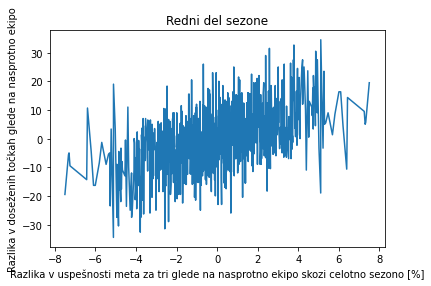

In [26]:
tekme_redne2.groupby("3P% DIFF SEASON")["PTS DIFF"].mean().plot(title="Redni del sezone", xlabel="Razlika v uspešnosti meta za tri glede na nasprotno ekipo skozi celotno sezono [%]", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v uspešnosti meta za tri glede na nasprotno ekipo skozi celotno sezono [%]', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

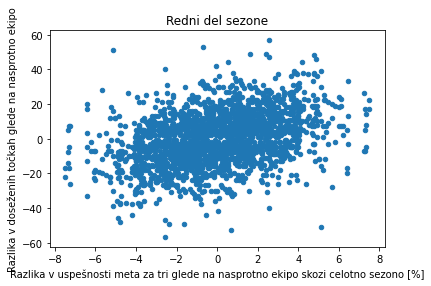

In [27]:
tekme_redne2.plot.scatter("3P% DIFF SEASON", "PTS DIFF", title="Redni del sezone", xlabel="Razlika v uspešnosti meta za tri glede na nasprotno ekipo skozi celotno sezono [%]", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v 3NG koeficientu glede na nasprotno ekipo', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

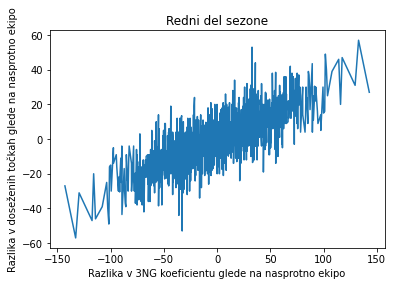

In [28]:
tekme_redne2.groupby("3NG DIFF")["PTS DIFF"].mean().plot(title="Redni del sezone", xlabel="Razlika v 3NG koeficientu glede na nasprotno ekipo", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v 3NG koeficientu glede na nasprotno ekipo', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

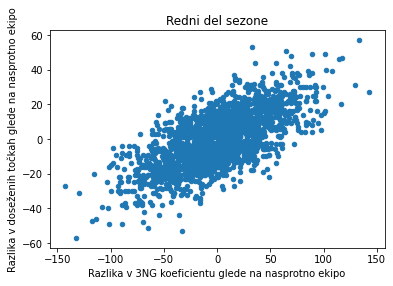

In [29]:
tekme_redne2.plot.scatter("3NG DIFF","PTS DIFF",title="Redni del sezone", xlabel="Razlika v 3NG koeficientu glede na nasprotno ekipo", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

Opazimo, da je graf odvisnosti razlike v točkah od koeficienta 3NG rahlo strmejši od grafa, ki ponazarja odvisnost razlike v točkah od uspešnosti meta. To nas lahko navede do razmišljanja, da je večji 3NG boljši kot uspešnejši met. Pri konstanti uspešnosti meta, 3NG ne bo konstanten, temveč se bo spreminjal glede na število metov za tri. Odvisnost 3NG od uspešnih in vseh metov za tri je prikazana na spodnjem grafu, na katerem je tudi jasno razvidno, da bo pri npr. 100% metu za tri točke 3NG naraščal s številom metov.

In [30]:
vrednosti_3NG = [[],[],[]]

for i in range(100):
    for j in range(i,100):
        vrednosti_3NG[0].append(i)
        vrednosti_3NG[1].append(j)
        vrednosti_3NG[2].append(3 * ((3 - expected_value) * i - expected_value * (j - i)))

data = {"3PM" : vrednosti_3NG[0], "3PA" : vrednosti_3NG[1], "3NG" : vrednosti_3NG[2]}
graf_3NG = pd.DataFrame(data)

C:\Users\mkocb\AppData\Local\Temp/ipykernel_11352/2154685817.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  threedee = plt.figure().gca(projection='3d')


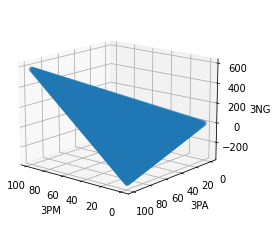

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

threedee = plt.figure().gca(projection='3d')
threedee.scatter(graf_3NG["3PM"], graf_3NG["3PA"], graf_3NG['3NG'])
threedee.set_xlabel('3PM')
threedee.set_ylabel('3PA')
threedee.set_zlabel('3NG')
threedee.view_init(15,130)
plt.show()

Prejšnji komentar glede 3NG nam, da idejo, da primerjamo ekipe, ki so približno enako uspešno metale za tri in pogledamo, kako je med njimi bilo pomembno število metov za tri točke. Naslednji graf prikazuje razlike v točkah na posameznih tekmah med ekipama, ki sta na tej tekmi približno enako dobro metali za tri, v odvisnosti od tega, kako veliko so ekipe metale za tri in kakšna je bila povprečna uspešnost meta za tri obeh ekip.

C:\Users\mkocb\AppData\Local\Temp/ipykernel_11352/3958025162.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  threedee = plt.figure().gca(projection='3d')


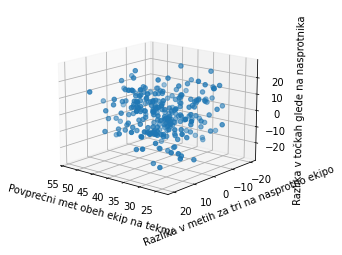

In [32]:
priblizno_enakovredne_tekme = tekme_redne2[abs(tekme_redne2["3P% DIFF"]) < 2]
threedee = plt.figure().gca(projection='3d')
threedee.scatter(priblizno_enakovredne_tekme["3P% AVG"], priblizno_enakovredne_tekme["3PA DIFF"], priblizno_enakovredne_tekme['PTS DIFF'])
threedee.set_xlabel('Povprečni met obeh ekip na tekmi')
threedee.set_ylabel('Razlika v metih za tri na nasprotno ekipo')
threedee.set_zlabel('Razlika v točkah glede na nasprotnika')
threedee.view_init(15,130)
plt.show()

Ker je ta 3D graf precej nepregleden, poglejmo 2D grafe za posamezne vrednost povprečnih metov obeh ekip.

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v metih za tri glede na nasprotno ekipo', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

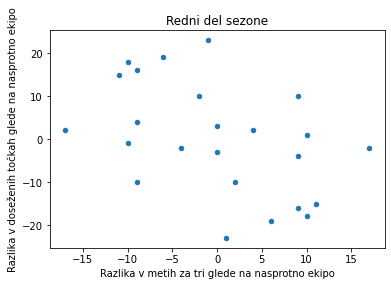

In [33]:
priblizno_enakovredne_tekme = tekme_redne2[(abs(tekme_redne2["3P% DIFF"]) < 2) & ((tekme_redne2["3P% AVG"] >= 25) & (tekme_redne2["3P% AVG"] <= 30))]
priblizno_enakovredne_tekme.plot.scatter("3PA DIFF","PTS DIFF",title="Redni del sezone", xlabel="Razlika v metih za tri glede na nasprotno ekipo", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v metih za tri glede na nasprotno ekipo', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

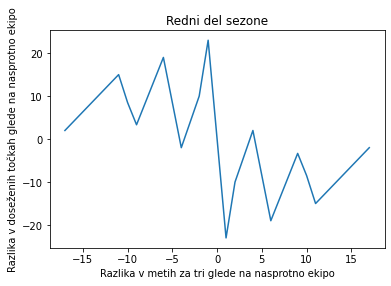

In [34]:
priblizno_enakovredne_tekme.groupby("3PA DIFF")["PTS DIFF"].mean().plot(title="Redni del sezone", xlabel="Razlika v metih za tri glede na nasprotno ekipo", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

Opazimo, da graf pokaže, da so na tekmah, kjer sta obe ekipi metali približno enako slabo za tri, praviloma izgubljale ekipe, ki so več metale za tri. Če pa pogledamo naslednje grafe, ki prikazujejo tekme, na katerih so ekipe za tri metale približno enako dobro in ne pretirano slabo, vidimo, da prejšnjega pravila več ne moremo zaslediti.

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v metih za tri glede na nasprotno ekipo', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

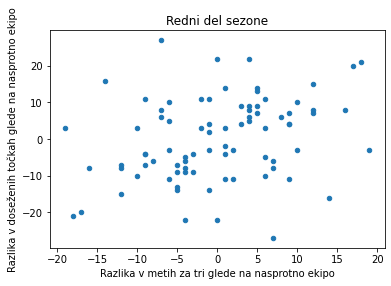

In [35]:
priblizno_enakovredne_tekme = tekme_redne2[(abs(tekme_redne2["3P% DIFF"]) < 2) & ((tekme_redne2["3P% AVG"] >= 35) & (tekme_redne2["3P% AVG"] <= 40))]
priblizno_enakovredne_tekme.plot.scatter("3PA DIFF","PTS DIFF",title="Redni del sezone", xlabel="Razlika v metih za tri glede na nasprotno ekipo", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v metih za tri glede na nasprotno ekipo', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

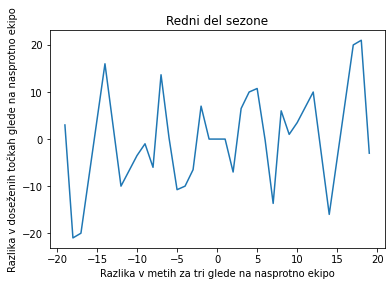

In [36]:
priblizno_enakovredne_tekme.groupby("3PA DIFF")["PTS DIFF"].mean().plot(title="Redni del sezone", xlabel="Razlika v metih za tri glede na nasprotno ekipo", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v metih za tri glede na nasprotno ekipo', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

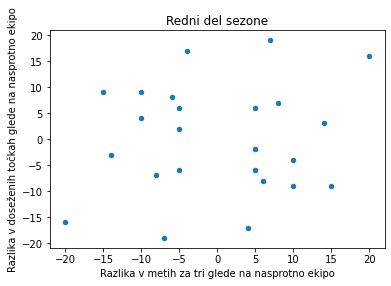

In [37]:
priblizno_enakovredne_tekme = tekme_redne2[(abs(tekme_redne2["3P% DIFF"]) < 2) & ((tekme_redne2["3P% AVG"] >= 45) & (tekme_redne2["3P% AVG"] <= 50))]
priblizno_enakovredne_tekme.plot.scatter("3PA DIFF","PTS DIFF",title="Redni del sezone", xlabel="Razlika v metih za tri glede na nasprotno ekipo", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v metih za tri glede na nasprotno ekipo', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

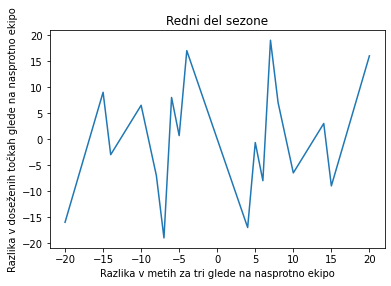

In [38]:
priblizno_enakovredne_tekme.groupby("3PA DIFF")["PTS DIFF"].mean().plot(title="Redni del sezone", xlabel="Razlika v metih za tri glede na nasprotno ekipo", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

Torej je število metov za tri pomembno le, če ekipe slabo mečejo za tri, in tedaj je, logično, boljše za takšne ekipe, da čim manj mečejo za tri.

Primerjajmo zdaj ekipe, ki so metale zelo veliko in zelo malo za tri, neodvisno od tega, kako dobro so metale za tri.

In [39]:
def precej_razlicne(zacetek, konec):
    zelo_razlicne = tekme_redne2[(abs(tekme_redne2["3PA DIFF"]) >= zacetek) & (abs(tekme_redne2["3PA DIFF"]) <= konec)]
    x = zelo_razlicne[(zelo_razlicne["3PA DIFF"] > 0) & (zelo_razlicne["PTS DIFF"] > 0)].count()["PTS DIFF"]
    y = zelo_razlicne[(zelo_razlicne["3PA DIFF"] < 0) & (zelo_razlicne["PTS DIFF"] > 0)].count()["PTS DIFF"]
    histogram = pd.DataFrame({"Način metanja" : ["Za dva", "Za tri"], "Število medsebojnih zmag" : [y, x]})
    histogram.plot.bar(title =f'Redne tekme, na katerih se je število metov za tri med ekipama razlikovalo za najmanj {zacetek} in največ {konec}', x = "Način metanja", y = "Število medsebojnih zmag").legend(loc='lower left')

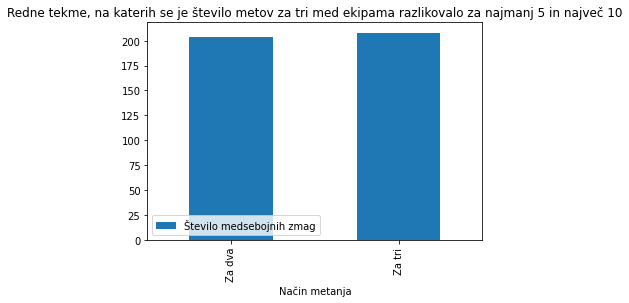

In [40]:
precej_razlicne(5,10)

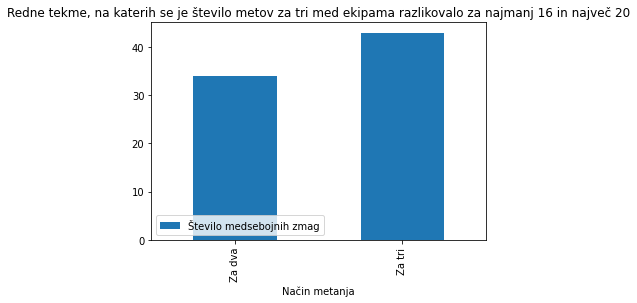

In [41]:
precej_razlicne(16,20)

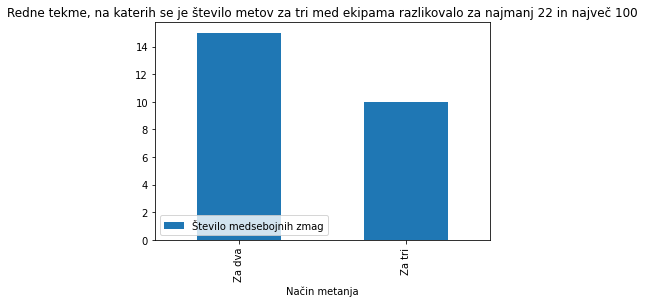

In [42]:
precej_razlicne(22,100)

Opazimo zanimiv pojav. Na tekmah, kjer razlika številu metov za tri med ekipama ni bila velika (5 do 10 metov), so približno enako pogosto zmagale (rahlo uspešnejše so bile ekipe, ki so metale več za tri točke), kar je bilo tudi pričakovano. Na tekmah, kjer je razlika v deležu meta za tri bila precejšnja, ne pa prevelika so, zanimivo, bile dosti uspešnejše ekipe, ki so več metale za tri. Še zanimiveje pa je, da se pri zelo velikih razlikah v deležu meta za tri, to razmerje obrne, in so veliko uspešnejše ekipe, ki so več metale za dve. Pri zadnji ugotovitvi, je treba imeti v vidu, da je takšnih tekem bilo le 25, in zato nimamo dovolj velikega vzorca, da bi lahko karkoli z gotovostjo trdili, imamo pa vseeno nek kazatelj.

Te ugotovitve nam porodijo več vprašanj:

1. Če število metov za tri predstavlja na posameznih tekmah nezanemarljiv faktor, zakaj je potem nepomemben, ko gledamo rezultate skozi celotno sezono (kot smo ugotovili na prejšnjih grafih)?
2. Zakaj so na tekmah, kjer je razlika v številu metov za tri bila precejšnja, ne pa prevelika, bile uspešnejše ekipe, ki so več metale za tri?
3. Zakaj se razmerje iz druge točke obrne v korist ekip, ki mečejo več za dva, ko razlika v številu metov za tri postane zelo velika?

Poskusimo odgovoriti oz. postaviti nove hipoteze:

1. Število tekem, na katerih je število metov za tri nezanemarljiv faktor, je 10-krat manjše od števila vseh tekem v sezoni, zato imajo te tekme precej majhen vpliv na statistiko cele sezone in zato postane število metov za tri zanemarljiv faktor, ko opazujemo celotno sezono.
2. Postavimo hipotezo, da so na takšnih tekmah več metale za tri ekipe, ki so se počutile samozavestno, ker so dejansko dobro metale za tri. To bomo preverili s primerjavo povprečnega 3NG faktorja ekip.
3. Postavimo hipotezo, da so na takšnih tekmah ekipe pretiravale s trojkami, čeprav niso dobro metale za tri. Tudi to bomo preverili s primerjavo 3NG faktorjev.

Opomba: Primerjali bomo 3NG, saj smo že pokazali, da je le-ta bistvenega pomena za uspešnost ekip, hkrati pa vzame v obzir tako uspešnost meta za tri kot tudi število metov za tri.

In [43]:
def primerjaj_3NG(zacetek, konec):
    zelo_razlicne = tekme_redne2[(abs(tekme_redne2["3PA DIFF"]) >= zacetek) & (abs(tekme_redne2["3PA DIFF"]) <= konec)]
    x = zelo_razlicne[(zelo_razlicne["3PA DIFF"] > 0) & (zelo_razlicne["PTS DIFF"] > 0)].mean()["3NG"]
    y = zelo_razlicne[(zelo_razlicne["3PA DIFF"] < 0) & (zelo_razlicne["PTS DIFF"] > 0)].mean()["3NG"]
    histogram = pd.DataFrame({"Način metanja" : ["Za dva", "Za tri"], "Povprečen 3NG" : [y, x]})
    histogram.plot.bar(title =f'Redne tekme, na katerih se je število metov za tri med ekipama razlikovalo za najmanj {zacetek} in največ {konec}', x = "Način metanja", y = "Povprečen 3NG").legend(loc='lower left')

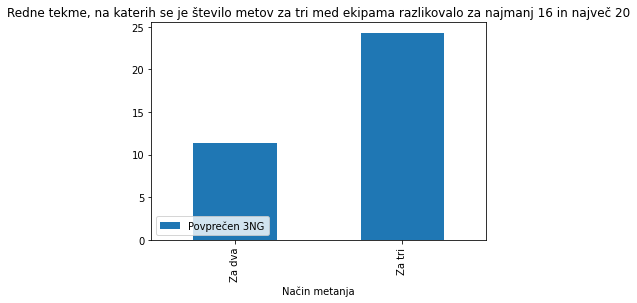

In [44]:
primerjaj_3NG(16,20)

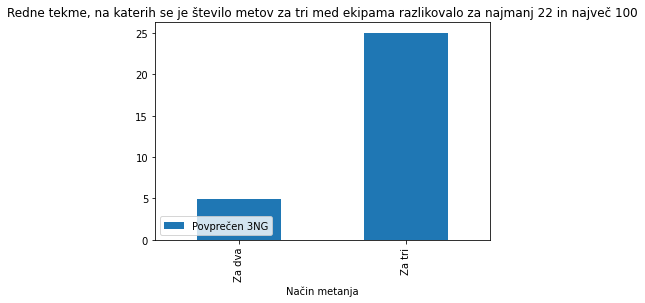

In [45]:
primerjaj_3NG(22,100)

S tem smo potrdili drugo hipotezo, saj je 3NG res dosti večji pri ekipah, ki so več metale za tri. Vendar je tretja hipoteza pogorela, saj so ekipe, ki so na tekmah opisanih v tretji točki več metale za tri, imele v povprečju drastično večji 3NG. 

Raziščimo najprej, kako vpliva uspešnost meta za tri in delež meta za tri med vsemi meti na ostale statistične podatke. Nato se bomo vrnili na tretje vprašanje in poskusili še enkrat nanj odgovoriti 

Opomba zame: Mogoče je le teh 25 tekem bilo čudnih in je zaradi majhnega vzorca tudi skupna statistika čudna, moraš tudi to preveriti na koncu.

# Vpliv načina igre na ostale statistike

Najprej poglejmo, kako uspešnost meta za tri in število metov za tri vpliva na število točk, ki jih je ekipa dala in prejela.

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Število metov za tri točke na tekmi', ylabel='Dosežene točke'>

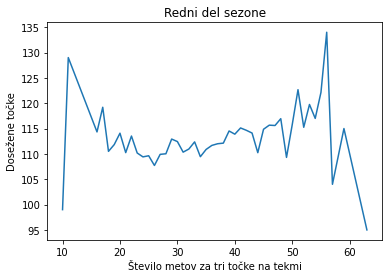

In [46]:
tekme_redne.groupby("3PA")["PTS"].mean().plot(title="Redni del sezone", xlabel="Število metov za tri točke na tekmi", ylabel="Dosežene točke")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Število metov za tri točke na tekmi', ylabel='Dosežene točke'>

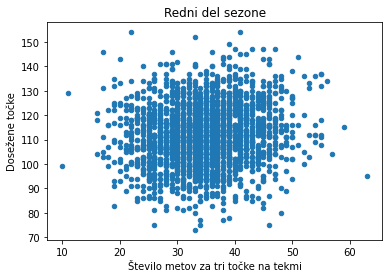

In [47]:
tekme_redne.plot.scatter("3PA","PTS",title="Redni del sezone", xlabel="Število metov za tri točke na tekmi", ylabel="Dosežene točke")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Število metov za tri točke na tekmi', ylabel='Nasprotnikove točke'>

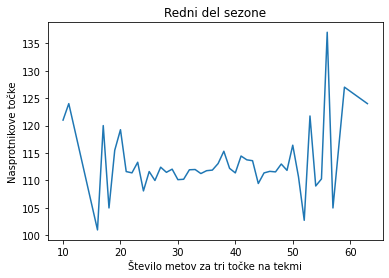

In [48]:
tekme_redne.groupby("3PA")["PTSA"].mean().plot(title="Redni del sezone", xlabel="Število metov za tri točke na tekmi", ylabel="Nasprotnikove točke")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Število metov za tri točke na tekmi', ylabel='Nasprotnikove točke'>

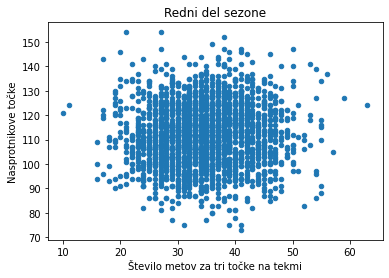

In [49]:
tekme_redne.plot.scatter("3PA","PTSA",title="Redni del sezone", xlabel="Število metov za tri točke na tekmi", ylabel="Nasprotnikove točke")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Število metov za tri točke na tekmi', ylabel='Število skokov na tekmi'>

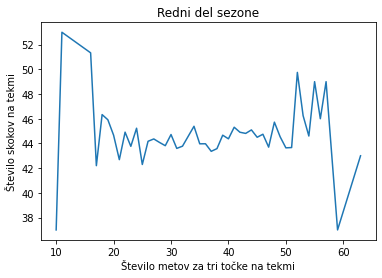

In [50]:
tekme_redne.groupby("3PA")["REB"].mean().plot(title="Redni del sezone", xlabel="Število metov za tri točke na tekmi", ylabel="Število skokov na tekmi")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Število metov za tri točke na tekmi', ylabel='Število skokov na tekmi'>

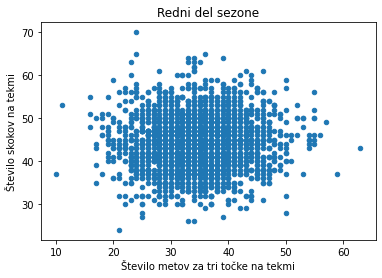

In [51]:
tekme_redne.plot.scatter("3PA","REB",title="Redni del sezone", xlabel="Število metov za tri točke na tekmi", ylabel="Število skokov na tekmi")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Število metov za tri točke na tekmi', ylabel='Asistence'>

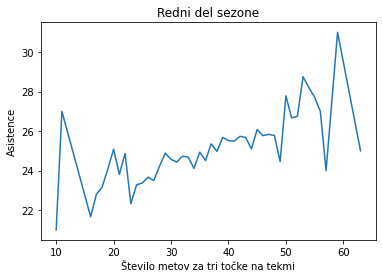

In [52]:
tekme_redne.groupby("3PA")["AST"].mean().plot(title="Redni del sezone", xlabel="Število metov za tri točke na tekmi", ylabel="Asistence")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Število metov za tri točke na tekmi', ylabel='Asistence'>

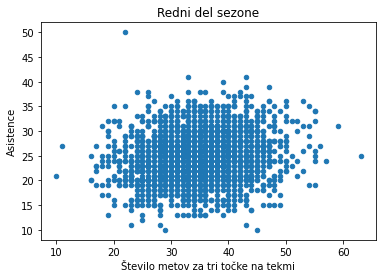

In [53]:
tekme_redne.plot.scatter("3PA","AST",title="Redni del sezone", xlabel="Število metov za tri točke na tekmi", ylabel="Asistence")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Število metov za tri točke v sezoni', ylabel='Točke v sezoni'>

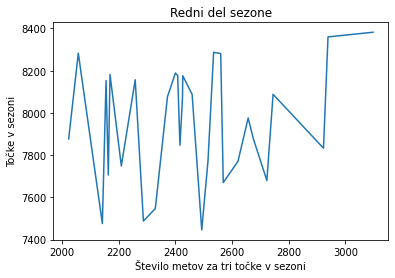

In [54]:
ekipe_redno.groupby("3PA")["PTS"].mean().plot(title="Redni del sezone", xlabel="Število metov za tri točke v sezoni", ylabel="Točke v sezoni")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Število metov za tri točke v sezoni', ylabel='Točke v sezoni'>

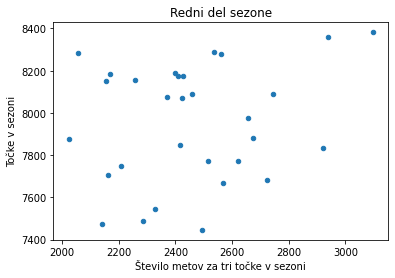

In [55]:
ekipe_redno.plot.scatter("3PA","PTS",title="Redni del sezone", xlabel="Število metov za tri točke v sezoni", ylabel="Točke v sezoni")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Število metov za tri točke v sezoni', ylabel='Skupne točke nasprotnikov v sezoni'>

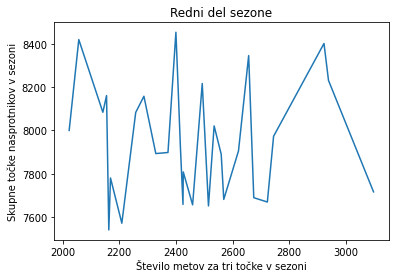

In [56]:
ekipe_redno.groupby("3PA")["PTSA"].mean().plot(title="Redni del sezone", xlabel="Število metov za tri točke v sezoni", ylabel="Skupne točke nasprotnikov v sezoni")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Število metov za tri točke v sezoni', ylabel='Skupne točke nasprotnikov v sezoni'>

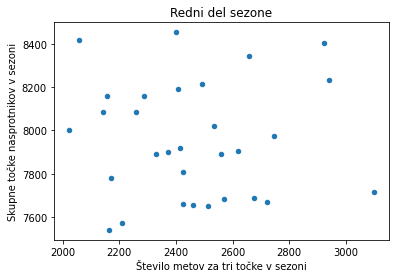

In [57]:
ekipe_redno.plot.scatter("3PA","PTSA",title="Redni del sezone", xlabel="Število metov za tri točke v sezoni", ylabel="Skupne točke nasprotnikov v sezoni")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Število metov za tri točke v sezoni', ylabel='Skupno število skokov v sezoni'>

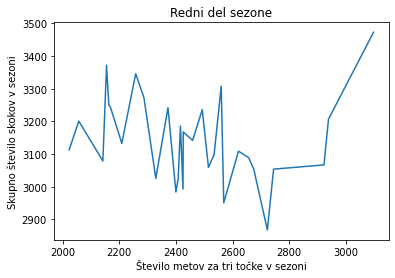

In [58]:
ekipe_redno.groupby("3PA")["REB"].mean().plot(title="Redni del sezone", xlabel="Število metov za tri točke v sezoni", ylabel="Skupno število skokov v sezoni")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Število metov za tri točke v sezoni', ylabel='Skupno število skokov v sezoni'>

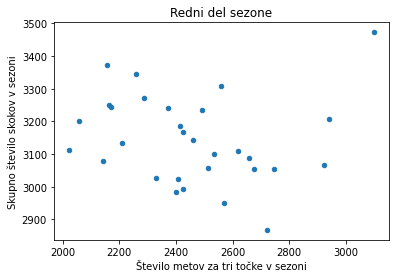

In [59]:
ekipe_redno.plot.scatter("3PA","REB",title="Redni del sezone", xlabel="Število metov za tri točke v sezoni", ylabel="Skupno število skokov v sezoni")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Število metov za tri točke v sezoni', ylabel='Skupno število skokov v sezoni'>

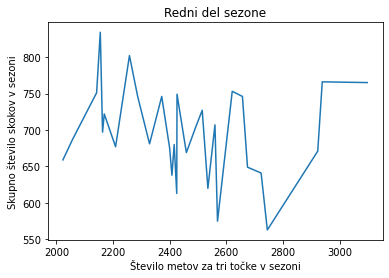

In [60]:
ekipe_redno.groupby("3PA")["OREB"].mean().plot(title="Redni del sezone", xlabel="Število metov za tri točke v sezoni", ylabel="Skupno število skokov v sezoni")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Število metov za tri točke v sezoni', ylabel='Skupno število skokov v napadu v sezoni'>

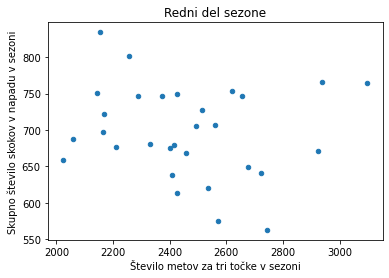

In [61]:
ekipe_redno.plot.scatter("3PA","OREB",title="Redni del sezone", xlabel="Število metov za tri točke v sezoni", ylabel="Skupno število skokov v napadu v sezoni")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Število metov za tri točke v sezoni', ylabel='Skupno število asistenc v sezoni'>

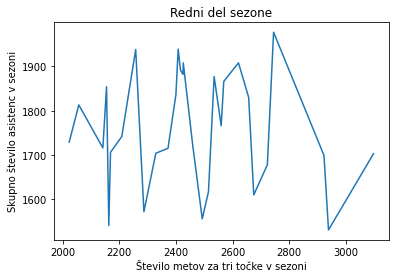

In [62]:
ekipe_redno.groupby("3PA")["AST"].mean().plot(title="Redni del sezone", xlabel="Število metov za tri točke v sezoni", ylabel="Skupno število asistenc v sezoni")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Število metov za tri točke v sezoni', ylabel='Skupno število asistenc v sezoni'>

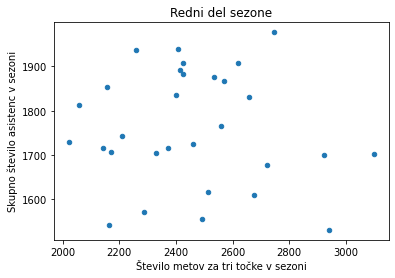

In [63]:
ekipe_redno.plot.scatter("3PA","AST",title="Redni del sezone", xlabel="Število metov za tri točke v sezoni", ylabel="Skupno število asistenc v sezoni")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Usepšnost meta za tri točke na tekmi', ylabel='Dosežene točke'>

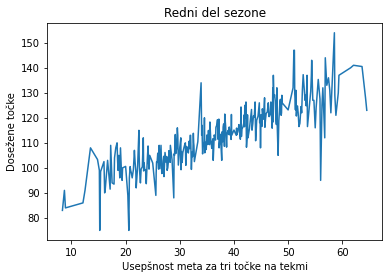

In [64]:
tekme_redne.groupby("3P%")["PTS"].mean().plot(title="Redni del sezone", xlabel="Usepšnost meta za tri točke na tekmi", ylabel="Dosežene točke")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Uspešnost meta za tri točke na tekmi', ylabel='Dosežene točke'>

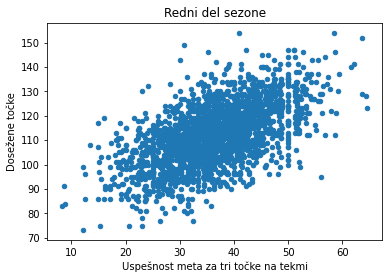

In [65]:
tekme_redne.plot.scatter("3P%","PTS",title="Redni del sezone", xlabel="Uspešnost meta za tri točke na tekmi", ylabel="Dosežene točke")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Uspešnost meta za tri točke na tekmi', ylabel='Nasprotnikove točke'>

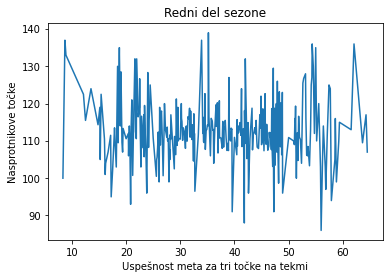

In [66]:
tekme_redne.groupby("3P%")["PTSA"].mean().plot(title="Redni del sezone", xlabel="Uspešnost meta za tri točke na tekmi", ylabel="Nasprotnikove točke")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Uspešnost meta za tri točke na tekmi', ylabel='Nasprotnikove točke'>

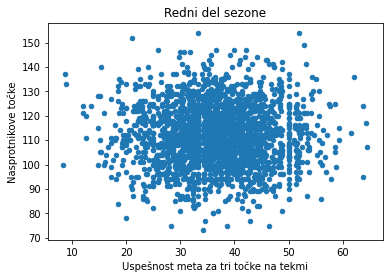

In [67]:
tekme_redne.plot.scatter("3P%","PTSA",title="Redni del sezone", xlabel="Uspešnost meta za tri točke na tekmi", ylabel="Nasprotnikove točke")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Uspešnost meta za tri točke na tekmi', ylabel='Število skokov na tekmi'>

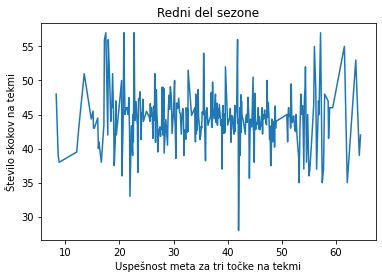

In [68]:
tekme_redne.groupby("3P%")["REB"].mean().plot(title="Redni del sezone", xlabel="Uspešnost meta za tri točke na tekmi", ylabel="Število skokov na tekmi")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Uspešnost meta za tri točke na tekmi', ylabel='Število skokov na tekmi'>

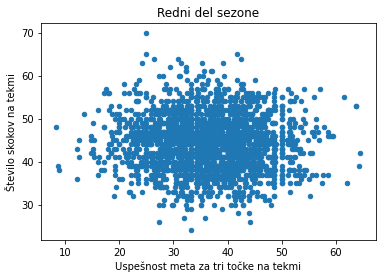

In [69]:
tekme_redne.plot.scatter("3P%","REB",title="Redni del sezone", xlabel="Uspešnost meta za tri točke na tekmi", ylabel="Število skokov na tekmi")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Uspešnost meta za tri točke na tekmi', ylabel='Asistence'>

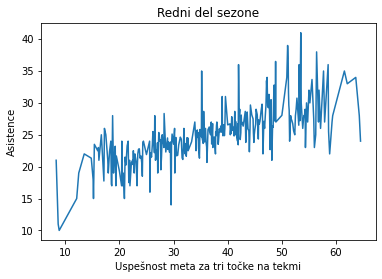

In [70]:
tekme_redne.groupby("3P%")["AST"].mean().plot(title="Redni del sezone", xlabel="Uspešnost meta za tri točke na tekmi", ylabel="Asistence")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Uspešnost meta za tri točke na tekmi', ylabel='Asistence'>

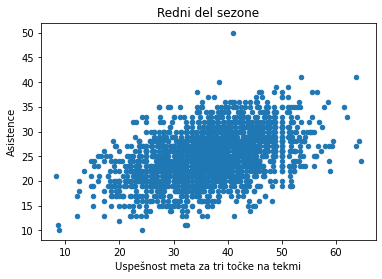

In [71]:
tekme_redne.plot.scatter("3P%","AST",title="Redni del sezone", xlabel="Uspešnost meta za tri točke na tekmi", ylabel="Asistence")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Uspešnost meta za tri točke v sezoni', ylabel='Točke v sezoni'>

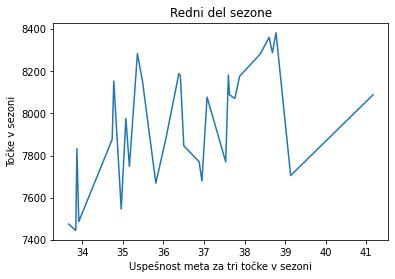

In [72]:
ekipe_redno.groupby("3P%")["PTS"].mean().plot(title="Redni del sezone", xlabel="Uspešnost meta za tri točke v sezoni", ylabel="Točke v sezoni")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Uspešnost meta za tri točke v sezoni', ylabel='Točke v sezoni'>

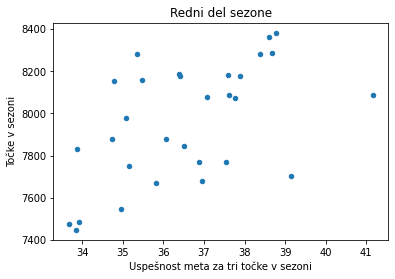

In [73]:
ekipe_redno.plot.scatter("3P%","PTS",title="Redni del sezone", xlabel="Uspešnost meta za tri točke v sezoni", ylabel="Točke v sezoni")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Uspešnost meta za tri točke v sezoni', ylabel='Skupne točke nasprotnikov v sezoni'>

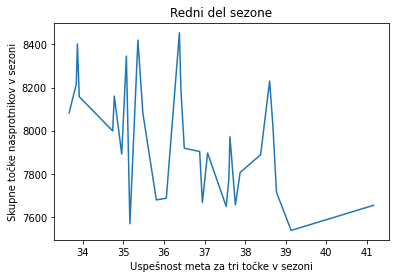

In [74]:
ekipe_redno.groupby("3P%")["PTSA"].mean().plot(title="Redni del sezone", xlabel="Uspešnost meta za tri točke v sezoni", ylabel="Skupne točke nasprotnikov v sezoni")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Uspešnost meta za tri točke v sezoni', ylabel='Skupne točke nasprotnikov v sezoni'>

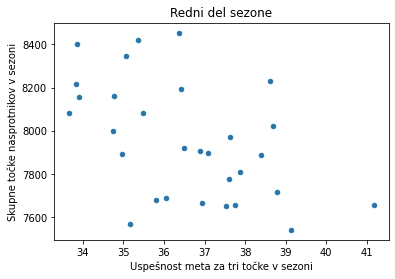

In [75]:
ekipe_redno.plot.scatter("3P%","PTSA",title="Redni del sezone", xlabel="Uspešnost meta za tri točke v sezoni", ylabel="Skupne točke nasprotnikov v sezoni")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Uspešnost meta za tri točke v sezoni', ylabel='Skupno število skokov v sezoni'>

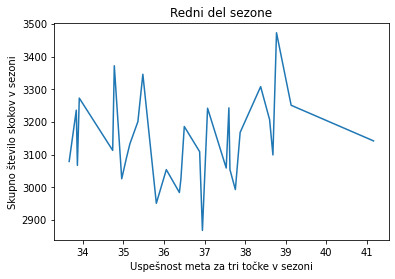

In [76]:
ekipe_redno.groupby("3P%")["REB"].mean().plot(title="Redni del sezone", xlabel="Uspešnost meta za tri točke v sezoni", ylabel="Skupno število skokov v sezoni")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Uspešnost meta za tri točke v sezoni', ylabel='Skupno število skokov v sezoni'>

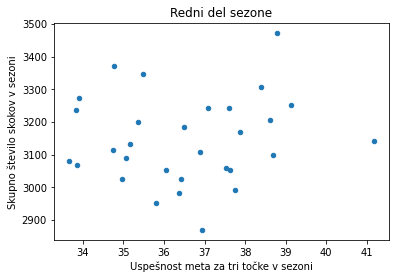

In [77]:
ekipe_redno.plot.scatter("3P%","REB",title="Redni del sezone", xlabel="Uspešnost meta za tri točke v sezoni", ylabel="Skupno število skokov v sezoni")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Uspešnost meta za tri točke v sezoni', ylabel='Skupno število skokov v sezoni'>

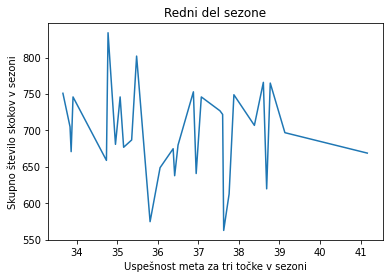

In [78]:
ekipe_redno.groupby("3P%")["OREB"].mean().plot(title="Redni del sezone", xlabel="Uspešnost meta za tri točke v sezoni", ylabel="Skupno število skokov v sezoni")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Uspešnost meta za tri točke v sezoni', ylabel='Skupno število skokov v napadu v sezoni'>

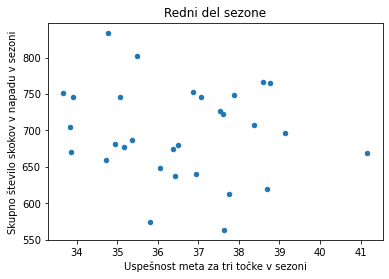

In [79]:
ekipe_redno.plot.scatter("3P%","OREB",title="Redni del sezone", xlabel="Uspešnost meta za tri točke v sezoni", ylabel="Skupno število skokov v napadu v sezoni")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Uspešnost meta za tri točke v sezoni', ylabel='Skupno število asistenc v sezoni'>

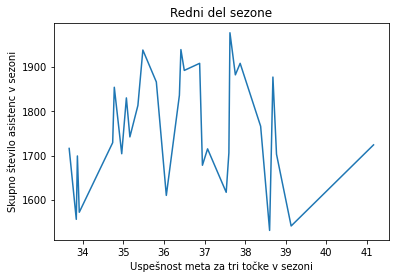

In [80]:
ekipe_redno.groupby("3P%")["AST"].mean().plot(title="Redni del sezone", xlabel="Uspešnost meta za tri točke v sezoni", ylabel="Skupno število asistenc v sezoni")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Uspešnost meta za tri točke v sezoni', ylabel='Skupno število asistenc v sezoni'>

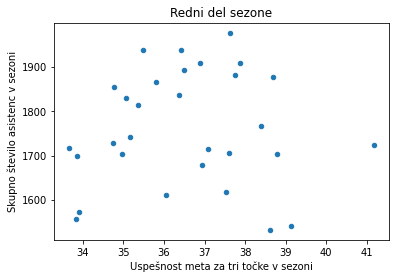

In [81]:
ekipe_redno.plot.scatter("3P%","AST",title="Redni del sezone", xlabel="Uspešnost meta za tri točke v sezoni", ylabel="Skupno število asistenc v sezoni")

# Napol Nostradamus

Napisal bom program, ki sprejme podatek o tem, kako uspešno sta dve ekipi metali za tri in kolikokrat sta metali za tri, in na podlagi tega poskusi uganiti končni rezultat tekme.

In [82]:
def zaokrozi_na_desetice(x):
    return x - (x % 10)

zdruzena_statistika = [[], [], [], [], []]

for i in range(tekme_redne["PTS"].size//2):
    zdruzena_statistika[0].append(tekme_redne["3P%"].iloc[2 * i])
    zdruzena_statistika[1].append(tekme_redne["3P%"].iloc[2 * i + 1])
    zdruzena_statistika[2].append(tekme_redne["3PA"].iloc[2 * i])
    zdruzena_statistika[3].append(tekme_redne["3PA"].iloc[2 * i + 1])
    zdruzena_statistika[4].append((zaokrozi_na_desetice(tekme_redne["PTS"].iloc[2 * i]), zaokrozi_na_desetice(tekme_redne["PTS"].iloc[2 * i + 1])))

data = {"3P% HOME" : zdruzena_statistika[0], "3P% AWAY" : zdruzena_statistika[1], "3PA HOME" : zdruzena_statistika[2],
    "3PA AWAY" : zdruzena_statistika[3], "Class" : zdruzena_statistika[4]}

zdruzene_tekme = pd.DataFrame(data)

In [83]:
verjetnosti_kategorij = zdruzene_tekme.groupby("Class").size()/len(zdruzene_tekme)
verjetnosti_kategorij = verjetnosti_kategorij.to_dict()

In [84]:
import random

def napovej(procenti1, meti1, procenti2, meti2):
    ustrezni = zdruzene_tekme[((abs(zdruzene_tekme["3P% HOME"] - procenti1) < 2) & (abs(zdruzene_tekme["3P% AWAY"] - procenti2) < 2)
                                & (abs(zdruzene_tekme["3PA HOME"] - meti1) < 10) & (abs(zdruzene_tekme["3PA AWAY"] - meti2) < 10)) |
                                ((abs(zdruzene_tekme["3P% HOME"] - procenti2) < 2) & (abs(zdruzene_tekme["3P% AWAY"] - procenti1) < 2)
                                & (abs(zdruzene_tekme["3PA HOME"] - meti2) < 10) & (abs(zdruzene_tekme["3PA AWAY"] - meti1) < 10))]
    
    pojavitve_po_kategorijah = ustrezni.groupby("Class").size().to_dict()

    max_kategorija = (0,0)
    mx = 0
    
    for kategorija in pojavitve_po_kategorijah.keys():
        if (pojavitve_po_kategorijah[kategorija]/zdruzene_tekme.groupby("Class").size()[kategorija]) * verjetnosti_kategorij[kategorija] > mx:
            max_kategorija = kategorija
            mx = (pojavitve_po_kategorijah[kategorija]/zdruzene_tekme.groupby("Class").size()[kategorija]) * verjetnosti_kategorij[kategorija]

    answer = (max_kategorija[0] + random.randrange(10), max_kategorija[1] + random.randrange(10))

    if answer[0] == answer[1]:
        if answer[0] == 0:
            answer[0] = answer[0] + 1
        else:
            answer[0] = answer[0] - 1
    
    return (max_kategorija[0] + random.randrange(10), max_kategorija[1] + random.randrange(10))


napovej(51.3, 39, 35.9, 39)

(107.0, 126.0)